Tài liệu này mang giấy phép Creative Commons Attribution (CC BY). (c) Nguyễn Ngọc Sáng, Zhukovsky 06/2019.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

# Bài 24. Bài toán dòng chảy quanh hình trụ, NACA0012, Crew Dragon. Điều kiện biên *joint, farfield*.

Để giải một bài toán bất kì, ta cần thay đổi: **lưới và thông số trong module setup**. 

## 1. Dòng chảy quanh hình trụ

**Bài toán:**
<br> Xác định dòng chảy quanh hình trụ bán kính 1m với thông số dòng chảy tự do: $T=293.15 (K), (u,v) = (40, 0) (m/s), p = 101325 (Pa)$

### a. Tạo lưới 
Để sử dụng các hàm tạo dữ liệu Cells, Sides đòi hỏi ta tạo lưới **đúng thứ tự quy ước** như khi tạo lưới cho bài toán dòng chảy trên âm. Tức là cần tạo lưới có các `biên` như trên hình (thứ tự theo chiều chỉ số i, j: biên 0, 1, 2, 3):
<img src='img/Bai_24_2.png' width = 500>

Đối với dòng chảy bao khi tạo lưới cần chú ý đến kích thước (độ dày) của lớp ô lưới đầu tiên trên bề mặt và tỉ lệ tăng kích thước này của hai lớp kế tiếp (thông thường lấy bằng 1.2).

In [3]:
# %cd lib
import numpy as np
import matplotlib.pyplot as plt
from functions import export_mesh

# Tạo lưới bài toán dòng chảy quanh hình trụ
def generate_mesh_cylinder(Nj, Ni):
    # chia góc 2Pi ra thành Ni điểm lưới 
    alpha = np.linspace(0.0, -2*np.pi, Ni)
    
    # bán kính tại các điểm lưới  
    r = np.zeros(Nj)
    r[0] = 1.0  # bán kính hình trụ 
    dr = 1e-2   # kích thước ('dộ dày') ô lưới đầu tiên sát biên (bề mặt trụ)
    ratio = 1.2 # tỷ lệ tăng kích thước ô lưới 
    for j in range(1, Nj):
        r[j] = r[j-1]+dr
        dr *= ratio 
    
    # tạo độ điểm lưới 
    points = np.zeros((Nj, Ni, 2))
    for j in range(Nj):
        for i in range(Ni):
            points[j, i, 0] = r[j]*np.cos(alpha[i])
            points[j, i, 1] = r[j]*np.sin(alpha[i])
    return points

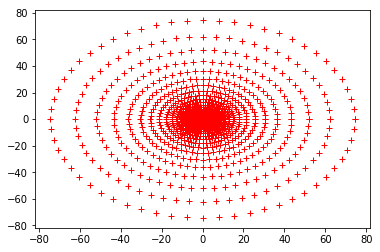

In [2]:
Nj = 41
Ni = 61
points = generate_mesh_cylinder(Nj, Ni)
plt.plot(points[:, :, 0], points[:, :, 1], 'r+')
plt.show()
# export_mesh(Nj, Ni, points, 'data/mesh_cylinder.dat')

### b. Điều kiện biên

Đối với bài toán dòng chảy trên âm ta có 4 điều kiện biên `(0, 1, 2, 3)` lần lượt là `(supersonic_inflow, supersonic_outflow, wall, wall)`. Còn với bài toán này thì sao? Dễ dàng nhận thấy: điều kiện tại `biên 2` là `wall`, `biên 0 và 1` trùng nhau ta gọi là `joint` (hay `điều kiện biên tuần hoàn`), `biên 3` ở xa bề mặt trụ ta gọi là `farfield` (khi tạo lưới chú ý để biên 3 ở `đủ xa` bề mặt trụ).

- **Điều kiện 'joint'**:
<br>`ô lưới bên trái biên 0 chính là ô lưới bên trái biên 1, ô lưới bên phải bên 1 chính là ô lưới bên phải biên 0 hay là side_0.cells[0] = side_1.cells[0], side_1.cells[1] = side_0.cells[1]` và khi đó các side ở trên biên trở thành inner_side (có đầy đủ hai ô lưới hai bên trái phải).
- **Điều kiện 'farfield'**:
<br>`nếu hướng vận tốc tại ô lưới phía trong biên là chảy vào thì thông số trên biên bằng thông số dòng tự do, ngược lại - thông số trên biên bằng thông số của ô lưới sát biên`:

Thêm vào định nghĩa lớp Sides và module boco các hàm sau:

In [ ]:
# Thêm vào định nghĩa lớp Sides, module 'data.py'

# Trường hợp điều kiện biên tuần hoàn
def set_joint(self, boundary_0, boundary_1):
    for side_0, side_1 in zip(boundary_0, boundary_1):
        side_0.cells[0] = side_1.cells[0] # set ô lưới bên trái của các side biên 0
        self.inner_sides.append(side_0)   # side_0 trở thành inner_side 

In [ ]:
# Thêm vào module boco.py

# Điều kiện biên farfield
def farfield(boundary, ic):
    for side in boundary:
        V_in = side.cells[ic].P[1:3]  # vận tốc tại ô lưới phía trong biên 
        Vn = -sign_ic(ic)*side.normal.dot(V_in)  # hướng vận tốc so với phương pháp tuyến (quay ra) của biên 
        if Vn >= 0: # chảy ra
            F = P2F(side.cells[ic].P, side)
        else: # chảy vào 
            F = P2F(P_freestream, side)
        side.cells[ic].res += sign_ic(ic) * F

# Điều kiện biên joint
def joint(boundary, ic):
    pass # vì các side trên biên đã trở thành inner_side nên không phải làm gì hết tại đây 

# ta có `từ điển` điều kiện biên: <tên gọi> : <hàm đkb>
boco_dict = {'supersonic_inflow': supersonic_inflow, 'supersonic_outflow': supersonic_outflow, 'wall': wall_no_slip, \
             'farfield': farfield, 'joint': joint}


### c. setup
Trong module setup ta thay đổi các thông thông số cần thiết:

In [4]:
# coding: utf-8
# Module setup.py

from numpy import array
from fluxes import flux_roe
from boco import boco_dict, set_freestream
from functions import P2U, rho

# cylinder
P_freestream = array([rho(293.15, 101325.0), 40, 0.0, 101325.0]) # freestream

def init_field(cells):
    P_t0 = P_freestream
    U_t0 = P2U(P_t0)
    for cell in cells[:]:
        cell.P = P_t0.copy()
        cell.U = U_t0.copy()
    
# điều kiện biên
def set_boco(sides):
    set_freestream(P_freestream)
    boco_name = ['joint', 'joint', 'wall', 'farfield']
    boco_func = [boco_dict[name] for name in boco_name]
    sides.set_joint(sides.boundary_0, sides.boundary_1)
    sides.set_boco(boco_func)

# các thông số khác
CFL = 0.45
time_target = 1.0
iter_target = None 

write_field_iter = 1000 # thời điểm ghi kết quả giữa chừng
flux_func = flux_roe

mesh_filename = 'data/cylinder_mesh.dat'
field_filename = 'data/cylinder_cell_data.dat'

### d. Kết quả

Chạy module **run.py**, dùng Paraview biểu diễn kết quả, ta dễ dàng nhận ra sự khác biệt của 'cell_data' và 'block_data' (hay khi sử dụng hàm show_field với porc=0 hoặc 1):
<img src='img\Bai_24_3.png' width = 500>
**Câu hỏi:** Tại sao lại có khoảng trống ở hình bên trái?

Sử dụng filter CellDataToPointData trong paraview để chuyển block_data về point_data:
- Bước 1. dùng ParaView mở file block_data
- Bước 2. Apply filter: CellDataToPointData
- Bước 3. xuất dữ liệu tại điểm lưới: save data -> 'filename.txt'

Paraview:
<img src='img\Bai_24_4.png' width = 500>
show_point_data:  
<img src='img\Bai_24_5.png' width = 500>


## 2. Dòng chảy quanh NACA0012, Crew Dragon

Đối với dòng chảy quanh những vật thể có hình dạng phức tạp hơn như NACA0012 hay Crew Dragon ta dùng phần mềm có sẵn để chia và xuất lưới ở dạng `.cgns` (xem trong folder data). Sau đó dùng `Paraview` để mở xem lưới, dùng `save data` để lưu lưới lại ở dạng `.dat` mà ta vẫn dùng. 

**Bài tập:** Tính toán dòng chảy bao quanh NACA0012 và Crew Dragon sử dụng lưới `.cgns` trong `folder data` với thông số ban đầu tùy ý.

Ví dụ kết quả:

NACA0012:
<img src='img\Bai_24_6.png'>
Crew Dragon:
<img src='img\Bai_24_7.png'>

# Kết luận

Vậy là sau 7 bài học ta đã xây dựng được nền móng cơ bản cho chương trình giải hệ phương trình Euler 2D. Chương trình có thể sử đụng để giải các bài toán dòng chảy bên trong hay chảy bao quanh vật. Tuy nhiên khả năng ứng dụng, độ chính xác cũng như tốc độ tính toán còn hạn chế. Để phát triển chương trình cần cải thiện các vấn đề trên bằng cách nghiên cứu, bổ sung một số vấn đề:
- mở rộng điều kiện biên
- sử dụng sơ đồ bậc cao
- sử dụng sơ đồ implicit
- bổ sung phương pháp tính dòng
- tính toán song song

Phần 3 `Thực hành CFD với Python!` kết thúc tại đây. Chúc các bạn sức khỏe và may mắn!